In [1]:
from datasets import load_dataset
from torchvision.transforms import Compose, Resize, ToTensor, Lambda
import torchvision.transforms.functional as TF
import torch
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
from torch.nn.utils.rnn import pad_sequence
from torchvision.transforms.functional import to_pil_image


c:\Users\belkh\Code\ml_final_project\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Directly load with splits if supported
datasets = load_dataset("jinmang2/ucf_crime")
datasets = datasets['train'].shuffle(seed=42)


c:\Users\belkh\Code\ml_final_project\.conda\Lib\site-packages\datasets\load.py:1486: FutureWarning: The repository for jinmang2/ucf_crime contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/jinmang2/ucf_crime
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [3]:
train_test_split = datasets.train_test_split(test_size=0.2, seed=42)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

train_val_split = train_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = train_val_split['train']
val_dataset = train_val_split['test']


In [4]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import cv2

class VideoDataset(Dataset):
    def __init__(self, dataset, target_fps=1, transform=None):
        self.dataset = dataset
        self.target_fps = target_fps
        self.transform = transform or transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),  # Resize frames to a smaller dimension
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.feature_extractor = models.mobilenet_v2(pretrained=True)
        self.feature_extractor.classifier[1] = torch.nn.Identity()  # Removing the final classifier layer
        self.feature_extractor.eval()

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        video_path = self.dataset[idx]['video_path']
        frames = self.load_video(video_path, self.target_fps)
        features = []
        with torch.no_grad():
            for frame in frames:
                frame = self.transform(frame)
                frame = frame.unsqueeze(0)  # Add batch dimension
                feature = self.feature_extractor(frame)
                features.append(feature.squeeze(0))
        features = torch.stack(features)
        label = self.dataset[idx]['anomaly']
        return features, label

    def load_video(self, video_path, target_fps):
        cap = cv2.VideoCapture(video_path)
        frames = []
        native_fps = cap.get(cv2.CAP_PROP_FPS)
        frame_ratio  = max(1, round(native_fps / target_fps))

        frame_idx = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if frame_idx % frame_ratio  == 0:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(frame)
            frame_idx += 1
        cap.release()
        return frames


In [5]:
from torch.utils.data import DataLoader

# Assuming 'datasets' is your loaded dataset, e.g., from Hugging Face or another source
train_dataset = VideoDataset(train_dataset)
val_dataset = VideoDataset(val_dataset)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

c:\Users\belkh\Code\ml_final_project\.conda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\belkh\Code\ml_final_project\.conda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.input_size = 1280  # Number of input features
        self.hidden_size = 256  # Number of features in hidden state
        self.num_layers = 1  # Number of LSTM layers
        self.num_classes = 2  # Number of output classes
        self.fc = nn.Linear(self.hidden_size, self.num_classes)  # Output layer assumes last hidden state as input
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True)


    def forward(self, x):
        # Forward pass through LSTM layer
        # x of shape (batch, seq, feature)
        output, (hn, cn) = self.lstm(x)
        # Assuming using the last hidden state
        out = self.fc(hn[-1])
        return out



In [7]:
def validate(model, val_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct_predictions = 0
    total_samples = 0
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            # Assuming outputs are logits and you are doing a classification task
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = correct_predictions / total_samples
    model.train()  # Set the model back to training mode
    return accuracy


torch.Size([1, 2645, 1280]) tensor([0])
torch.Size([1, 14, 1280]) tensor([0])
torch.Size([1, 34, 1280]) tensor([0])
torch.Size([1, 94, 1280]) tensor([0])
torch.Size([1, 31, 1280]) tensor([0])
torch.Size([1, 39, 1280]) tensor([1])
torch.Size([1, 141, 1280]) tensor([0])
torch.Size([1, 63, 1280]) tensor([1])
torch.Size([1, 36, 1280]) tensor([1])
torch.Size([1, 14, 1280]) tensor([1])
torch.Size([1, 3600, 1280]) tensor([0])
torch.Size([1, 45, 1280]) tensor([0])
torch.Size([1, 61, 1280]) tensor([0])
torch.Size([1, 10, 1280]) tensor([1])
torch.Size([1, 103, 1280]) tensor([1])
torch.Size([1, 48, 1280]) tensor([1])
torch.Size([1, 25, 1280]) tensor([0])
torch.Size([1, 2662, 1280]) tensor([0])
torch.Size([1, 57, 1280]) tensor([0])
torch.Size([1, 141, 1280]) tensor([0])
torch.Size([1, 64, 1280]) tensor([0])
torch.Size([1, 110, 1280]) tensor([0])
torch.Size([1, 175, 1280]) tensor([0])
torch.Size([1, 27, 1280]) tensor([1])
torch.Size([1, 38, 1280]) tensor([0])
torch.Size([1, 71, 1280]) tensor([0])
t

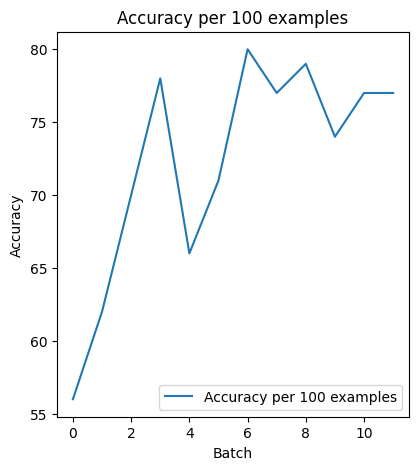

torch.Size([1, 94, 1280]) tensor([0])
torch.Size([1, 36, 1280]) tensor([0])
torch.Size([1, 16, 1280]) tensor([1])
torch.Size([1, 308, 1280]) tensor([1])
torch.Size([1, 61, 1280]) tensor([0])
torch.Size([1, 51, 1280]) tensor([0])
torch.Size([1, 543, 1280]) tensor([1])
torch.Size([1, 93, 1280]) tensor([1])
torch.Size([1, 15, 1280]) tensor([0])
torch.Size([1, 48, 1280]) tensor([1])
torch.Size([1, 1231, 1280]) tensor([0])
torch.Size([1, 13, 1280]) tensor([1])
torch.Size([1, 68, 1280]) tensor([0])
torch.Size([1, 57, 1280]) tensor([0])
torch.Size([1, 180, 1280]) tensor([1])
torch.Size([1, 71, 1280]) tensor([1])
torch.Size([1, 8, 1280]) tensor([0])
torch.Size([1, 60, 1280]) tensor([1])
torch.Size([1, 16, 1280]) tensor([0])
torch.Size([1, 69, 1280]) tensor([0])
torch.Size([1, 13, 1280]) tensor([0])
torch.Size([1, 240, 1280]) tensor([0])
torch.Size([1, 134, 1280]) tensor([1])
torch.Size([1, 37, 1280]) tensor([1])
torch.Size([1, 185, 1280]) tensor([0])
torch.Size([1, 461, 1280]) tensor([0])
torc

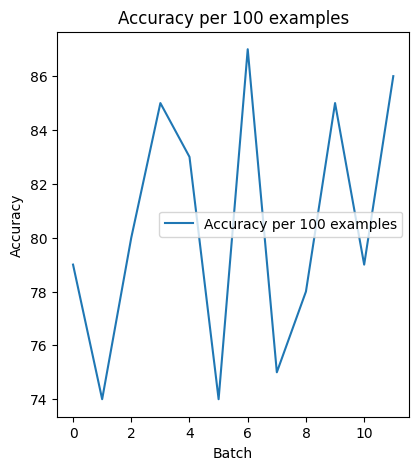

torch.Size([1, 6028, 1280]) tensor([0])
torch.Size([1, 50, 1280]) tensor([1])
torch.Size([1, 253, 1280]) tensor([0])
torch.Size([1, 81, 1280]) tensor([1])
torch.Size([1, 174, 1280]) tensor([1])
torch.Size([1, 65, 1280]) tensor([0])
torch.Size([1, 90, 1280]) tensor([0])
torch.Size([1, 19, 1280]) tensor([1])
torch.Size([1, 75, 1280]) tensor([0])
torch.Size([1, 1125, 1280]) tensor([0])
torch.Size([1, 36, 1280]) tensor([1])
torch.Size([1, 449, 1280]) tensor([0])
torch.Size([1, 159, 1280]) tensor([0])
torch.Size([1, 290, 1280]) tensor([0])
torch.Size([1, 64, 1280]) tensor([1])
torch.Size([1, 78, 1280]) tensor([0])
torch.Size([1, 143, 1280]) tensor([0])
torch.Size([1, 63, 1280]) tensor([0])
torch.Size([1, 104, 1280]) tensor([1])
torch.Size([1, 396, 1280]) tensor([0])
torch.Size([1, 15, 1280]) tensor([0])
torch.Size([1, 555, 1280]) tensor([0])
torch.Size([1, 106, 1280]) tensor([0])
torch.Size([1, 30, 1280]) tensor([1])
torch.Size([1, 120, 1280]) tensor([0])
torch.Size([1, 57, 1280]) tensor([1

In [8]:
import matplotlib.pyplot as plt

def train(model, data_loader, val_loader, criterion, optimizer, num_epochs, device, save_path='best_model.pth'):
    model = model.to(device)
    previous_val_accuracy = 0
    best_val_accuracy = 0

    for epoch in range(num_epochs):
        model.train()
        total_correct = 0
        total_samples = 0
        batch_losses = []
        batch_accuracies = []
        train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)


        for i, (inputs, labels) in enumerate(train_loader):
            print(inputs.shape, labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            batch_losses.append(loss.item())

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate batch accuracy
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels).sum().item()
            total_correct += correct
            total_samples += labels.size(0)

            if (i + 1) % 100 == 0:
                batch_accuracy = 100.0 * total_correct / total_samples
                batch_accuracies.append(batch_accuracy)
                print(f'Epoch {epoch+1}, Step {i+1}, Loss: {sum(batch_losses) / len(batch_losses):.4f}, '
                      f'Accuracy: {batch_accuracy:.2f}%')
                total_correct = 0
                total_samples = 0
                batch_losses = []

        # Validation after each epoch
        val_accuracy = validate(model, val_loader, device)
        print(f'Epoch {epoch+1}: Validation Accuracy: {val_accuracy:.4f}')

        # Saving the model if it has the best validation loss
        if val_accuracy < best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), save_path)
            print(f'Saved best model to {save_path}')

        # Early stopping condition (less than 10% decrease)
        if val_accuracy < 0.9 * previous_val_accuracy:
            print("Stopping early due to less than 10% decrease in validation loss.")
            break
        previous_val_accuracy = val_accuracy

        # Plotting
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(batch_accuracies, label='Accuracy per 100 examples')
        plt.title('Accuracy per 100 examples')
        plt.xlabel('Batch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.show()

    # Optionally save the final model state
    final_model_path = 'final_model.pth'
    torch.save(model.state_dict(), final_model_path)
    print(f'Saved final model state to {final_model_path}')

# Assumptions about other components of your setup
model = LSTM()  # Your LSTM model
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming 'train_loader' and 'val_loader' are defined (your DataLoader instances)
train(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, device=device)



In [9]:
# Load the test dataset
test_dataset = VideoDataset(test_dataset)  # Assuming datasets['test'] is your test set

# Create a DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)


c:\Users\belkh\Code\ml_final_project\.conda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\belkh\Code\ml_final_project\.conda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [1]:
modelFinal = LSTM()
modelFinal.load_state_dict(torch.load('best_model.pth'))

NameError: name 'LSTM' is not defined

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def test(model, data_loader, device):
    model = model.to(device)
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    counter = 0
    with torch.no_grad():  # Disable gradient computation
            for inputs, labels in data_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_predictions += (predicted == labels).sum().item()
                total_predictions += labels.size(0)
                counter += 1
                print(predicted, labels, correct_predictions, total_predictions)
    
    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy

# Evaluate the model
test_loss, test_accuracy = test(modelFinal, test_loader, device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

tensor([0], device='cuda:0') tensor([1], device='cuda:0') 0 1
tensor([1], device='cuda:0') tensor([1], device='cuda:0') 1 2
tensor([0], device='cuda:0') tensor([1], device='cuda:0') 1 3
tensor([0], device='cuda:0') tensor([1], device='cuda:0') 1 4
tensor([0], device='cuda:0') tensor([0], device='cuda:0') 2 5
tensor([0], device='cuda:0') tensor([0], device='cuda:0') 3 6
tensor([1], device='cuda:0') tensor([1], device='cuda:0') 4 7
tensor([0], device='cuda:0') tensor([0], device='cuda:0') 5 8
tensor([0], device='cuda:0') tensor([1], device='cuda:0') 5 9
tensor([0], device='cuda:0') tensor([1], device='cuda:0') 5 10
tensor([1], device='cuda:0') tensor([1], device='cuda:0') 6 11
tensor([0], device='cuda:0') tensor([1], device='cuda:0') 6 12
tensor([1], device='cuda:0') tensor([1], device='cuda:0') 7 13
tensor([0], device='cuda:0') tensor([0], device='cuda:0') 8 14
tensor([1], device='cuda:0') tensor([1], device='cuda:0') 9 15
tensor([0], device='cuda:0') tensor([0], device='cuda:0') 10 16
